
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 1 - Local Search <br>
<font color=696880 size=4>
Ali Aghayari


____

# Personal Data

In [ ]:
#Set your student number
student_number = '401106663'
Name = 'Arian'
Last_Name = 'Noori'

# Rules

<font color=red>
Please run all the cells.
</font>

# Libraries

In [ ]:
!pip install tsp_solver2

In [1]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
import itertools
from tsp_solver.greedy import solve_tsp


# Q1: TSP problem

## Problem Definition

Consider the Euclidean  [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):</br>
- In this problem, we are considering a country with n cities that are randomly placed; our country is a 1000 by 1000 square; we want to find the shortest tour for this country using their coordinates.
- A tour is a cycle that passes each city precisely one time.
- In this notebook we will develop some solutions to the problem, and more generally show how to think about solving a problem like this.



## Problem Representation (20 Points)

 We want to create our problem structure and present some valuable methods in this part.
 - init: choose your problem structure and create the variables accordingly.
 - distance: take two cities and return the distance between them.
 - tour length: get a tour and return the length of the given tour.
 - The shortest tour: get a set of tours and return the shortest one.
 - plot tour: get a tour and plot tour of the country.
 - nearest_neighbor: get a semi-tour and return to the nearest city to the last element you have yet to visit.

In [2]:
class TSP:
    
    def __init__(self, num_cities, cities = None):
        #set the number:
        self.num_cities = num_cities
        
        #set the cities:
        if cities != None :
            self.cities = cities
        else :
            self.cities = []
            while len(self.cities) != num_cities :
                self.cities.append((random.randint(0, 1000), random.randint(0, 1000)))
                
        #set the distances:
        self.distances = [[self.distance(i, j) for j in range(len(self.cities))] for i in range(len(self.cities))]
        pass

    def distance(self, A, B):
        
        #get the coordinates:
        x1 , y1 = self.cities[A]
        x2 , y2 = self.cities[B]
        
        length = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        
        return length

    def tour_length(self, tour):
        #calculate the length from start to end:
        length = 0
        for i in range(len(tour) - 1) :
            length += self.distance(self.cities.index(tour[i]),self.cities.index(tour[i + 1]))
        
        #and from end to start:
        length += self.distance(self.cities.index(tour[0]) , self.cities.index(tour[-1]))
        return length

    def shortest_tour(self, tours):
        
        #set infinity at first and try to find the shortest tour:
        shortest_length = float('inf')
        shortest_tour = None
        for i in range(len(tours)) :
            if shortest_length > self.tour_length(tours[i]) :
                shortest_length = self.tour_length(tours[i])
                shortest_tour = tours[i]
        return ((shortest_tour, shortest_length))

    def plot_tour(self, tour):
        for i in range(len(tour)) :
            plt.plot([tour[i][0],tour[(i + 1) % len(tour)][0]], [tour[i][1],tour[(i + 1) % len(tour)][1]], color = 'blue')
        plt.show()
        return

    def nearest_neighbor(self, A, cities, count = None):
        distances = [(self.distance(self.cities.index(A), self.cities.index(city)), city) for city in cities]
        array = sorted(distances , key = lambda x: x[0])
        if count != None :
            closest_cities = []
            for i in range(count) :
                closest_cities.append(array[i][1])
            return (closest_cities)
        else :
            return (array[0][1])

## Brute Force (5 Points)

Let's start with an algorithm that is guaranteed to solve the problem (although it is inefficient for large sets of cities) </br>
we can achieve this by generating all possible tours of the cities and choosing the shortest tour (the one with minimum tour length).

In [3]:
def alltours_tsp(tsp):
    tours = list(map(list, itertools.permutations(tsp.cities)))
    return tsp.shortest_tour(tours)

Now, try to create a country with five cities and apply your brute force function to find the shortest tour.

In [4]:
tsp = TSP(5)
shortest_tour , shortest_distance = alltours_tsp(tsp)
print("CITIES:" , shortest_tour)
print("SHORTEST_DISTANCE:" , shortest_distance)

CITIES: [(832, 791), (595, 835), (445, 746), (775, 368), (918, 357)]
SHORTEST_DISTANCE: 1503.1079342459207


Visualize your answer for the TSP problem

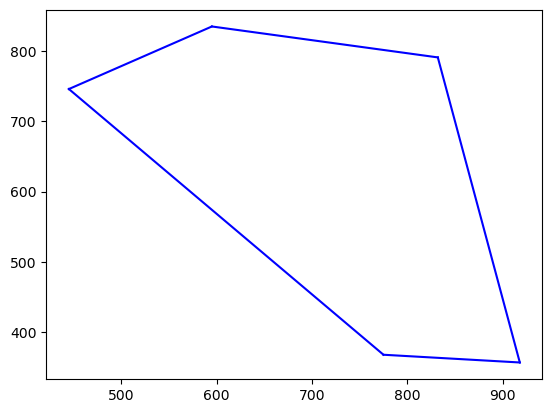

In [5]:
tsp.plot_tour(shortest_tour)



Try this algorithm on countries with 4, 6, 8, and 10 cities and plot the time it takes to calculate the answer.

[-11.511568354035429, -6.325779992623831, -1.2859334672386353, 3.5398246442878354]


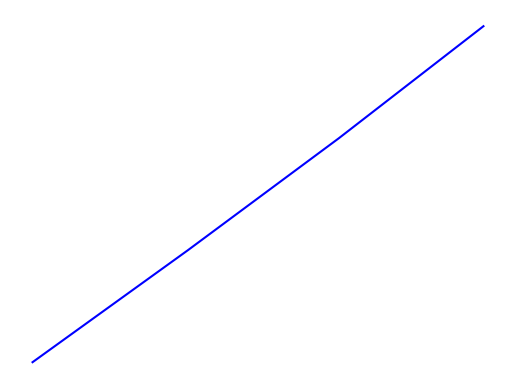

In [8]:
times = []
numbers = [4 , 6 , 8 , 10]
for i in range (4):
    tsp = TSP(numbers[i])
    start = time.time()
    alltours_tsp(tsp)

    #I add a small offset to avoid math domain error!
    end = time.time() + 0.00001
    times.append(math.log(end - start))

print(times)
plt.plot(times, range(len(times)) , color = 'blue')
plt.axis('off')
plt.grid(False)
plt.show()

## local Algorithms

### Initial Functions (25 Points)

We will create some functions for our initial state and use these functions for our local algorithms later.

- random initial function: Create a feasible tour randomly.

In [9]:
def random_initial(tsp):
    #using this method which I'm not familiar with to get random tour
    random_tour = random.sample(tsp.cities , tsp.num_cities)
    return random_tour , tsp.tour_length(random_tour)

- nearest neighbor initial function: Start at any city; at each step, extend the tour by moving from the previous city to its nearest neighbor that has yet to be visited.

In [10]:
def nearest_neighbor_initial(tsp):
    tour = []
    cities = tsp.cities.copy()
    random_start = random.randint(0, tsp.num_cities - 1)
    city = cities[random_start]
    tour.append(city)
    for _ in range(tsp.num_cities - 1):
        cities.remove(city)
        city = tsp.nearest_neighbor(city, cities)
        tour.append(city)
    return tour, tsp.tour_length(tour)

- repeated nearest neighbor initial function : You can improve nearest neighbor algorithm by running it multiple times with different starting cities and using the best-generated answer.

In [11]:
def repeated_nearest_neighbor_initial(tsp , repetitions = None):
    if repetitions == None :
        repetitions = tsp.num_cities

    #set the length to infinity and then search:
    shortest_length = float('inf')
    shortest_tour = None
    for i in range(repetitions) :
        tour , length = nearest_neighbor_initial(tsp)
        if length < shortest_length :
            shortest_length = length
            shortest_tour = tour
    return shortest_tour , shortest_length

Now, try to create a country with 30 cities, apply your repeated_nearest_neighbor_initial function with repetitions of 1, 4, 8, 12, and compare the results.

In [12]:
tsp = TSP(30)
tours = []
numbers = [1, 4, 8, 12]

for number in numbers:
    tours.append(repeated_nearest_neighbor_initial(tsp, number))

lengths = [tour[1] for tour in tours]
print(lengths)

[4744.528277415243, 5515.749888130268, 5051.831528085811, 4867.714887946043]


Does repetition make our answer optimal? "your short answer here!"

No, repetition does not guarantee an optimal solution. Increasing the number of repetitions in the nearest neighbor algorithm may improve the initial solution, but it does not guarantee an optimal solution.

- beam search initial function: Start with a list of n cities; at each step, extend your semi-tours by moving from their previous cities to their n nearest neighbors and then pick out n semi-tours from these generated semi-tours of length i+1

In [13]:
def beam_search_initial(tsp, n, iter_limit):
    # As the TA said we are able to assume that the "iter" (which I changed it's name to iter_limit) is a constant
    # , which is at most the number of the cities.
    iter_limit = tsp.num_cities - 1
    tours = [[] for _ in range(n)]
    starting_cities = []
    
    i = 0
    while i < n:
        random_start = random.randint(0, tsp.num_cities - 1)
        starting_cities.append(tsp.cities[random_start])
        tours[i].append(starting_cities[i])
        i += 1

    
    for i in range(iter_limit):
        n = min(n , iter_limit - i)
        all_tours = [[] for _ in range(n * n)]

        for j in range(n):
            for k in range(n): 
                all_tours[n * j + k] = tours[j].copy() + [tsp.nearest_neighbor(starting_cities[j], 
                                                        [city for city in tsp.cities if city not in tours[j]], n)[k]]

        tours.clear()  # Clear the contents of the tours list
        starting_cities.clear()
        
        j = 0
        while j < n:
            tours.append(sorted([(tsp.tour_length(tour), tour) for tour in all_tours],key=lambda x: x[0])[j][1].copy())
            starting_cities.append(tours[j][-1])
            j += 1

    
    return tours[0] , tsp.tour_length(tours[0])


Now, try to create a country with 30 cities, apply these initial functions, and compare the tour length of these initial tours with each other and the optimal answer (if city_num is low).

In [14]:
tsp = TSP(30)
random_initial_tour , random_initial_length = random_initial(tsp)
nearest_neighbor_initial_tour , nearest_neighbor_initial_length = nearest_neighbor_initial(tsp)
repeated_nearest_neighbor_initial_tour , repeated_nearest_neighbor_initial_length = repeated_nearest_neighbor_initial(tsp,10)
beam_search_initial_tour , beam_search_initial_length = beam_search_initial(tsp , 5 , 100)
print("random: ",random_initial_length)
print("nn: ", nearest_neighbor_initial_length)
print("rnn: ",repeated_nearest_neighbor_initial_length)
print("beam search: ",beam_search_initial_length)

random:  16926.717104500513
nn:  5671.456959961128
rnn:  5175.830181635559
beam search:  5914.294994904271


Plot these tours and compare them visually.

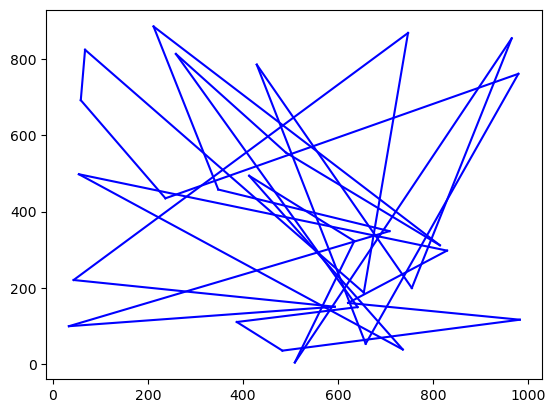

In [15]:
tsp.plot_tour(random_initial_tour)

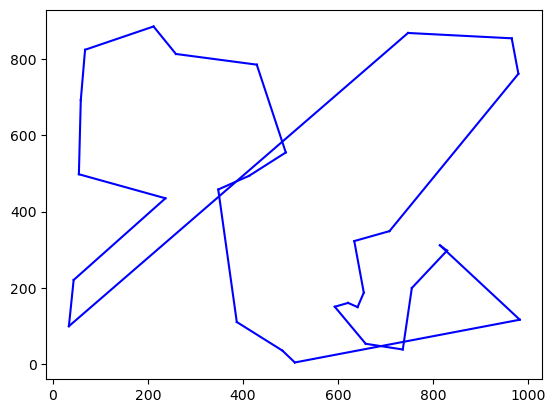

In [16]:
tsp.plot_tour(nearest_neighbor_initial_tour)

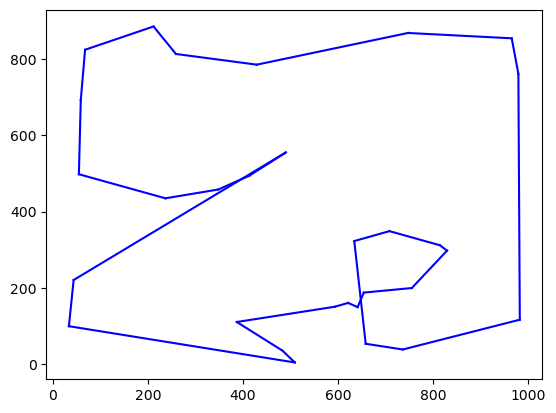

In [17]:
tsp.plot_tour(repeated_nearest_neighbor_initial_tour)

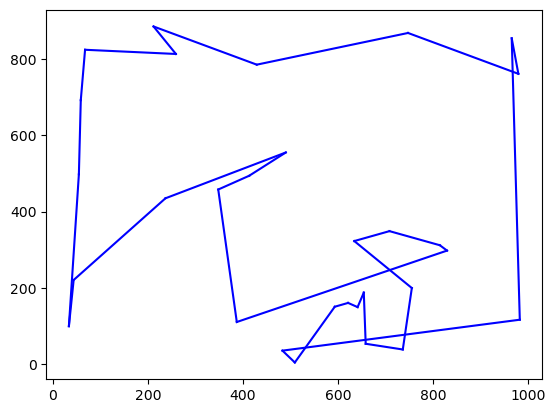

In [18]:
tsp.plot_tour(beam_search_initial_tour)

### LKH (25 Points)

Implement a simplified version of [LKH](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwimj7nFoqCEAxWzh_0HHc98Df4QFnoECCQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLin%25E2%2580%2593Kernighan_heuristic&usg=AOvVaw0G05-wkkun1YAp6zPfWuLd&opi=89978449) for this problem.</br>
- This local search algorithm takes the initial state and improves it over time by swapping a part of the tour sequence.
- In this modified version, we will check every (i,j) pair at each iteration and reverse the tour from index "I" to index "J" if it improves our tour.


In [19]:
def lin_kernighan(tsp, initial, iterations=10):
    for _ in range(iterations):
        for i in range(len(initial)):
            for j in range(i, len(initial)):
                temp_tour = initial[:]
                temp_tour[i:j + 1] = reversed(temp_tour[i:j + 1])
                if tsp.tour_length(temp_tour) < tsp.tour_length(initial):
                    initial = temp_tour
    return initial, tsp.tour_length(initial)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

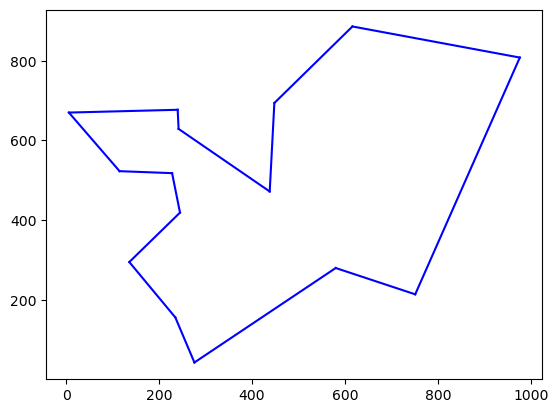

3435.4424544596404


In [20]:
tsp = TSP(15)
initial_tour = []
cities = tsp.cities.copy()  # Use copy() method to make a copy of the list
while len(cities) != 0 :
    randomStart = random.randint(0,len(cities) - 1)
    initial_tour.append(cities[randomStart])
    cities.remove(cities[randomStart])
tour , length = lin_kernighan(tsp,initial_tour)
tsp.plot_tour(tour)
print(length)

### Simulated Annealing (25 Points)

Implement simulated annealing for this problem.

In [21]:
def simulated_annealing(tsp, initial_tour, initial_temperature=1000, cooling_rate=0.99, num_iterations=10000):
    temperature = initial_temperature
    num_cities = tsp.num_cities
    for _ in range(num_iterations):
        if temperature <= 0:
            return initial_tour, tsp.tour_length(initial_tour)
        i = random.randint(0, num_cities - 1)
        j = random.randint(0, num_cities - 1)
        if i > j:
            i, j = j, i  # Swap i and j if i > j
        temp_tour = initial_tour[:]
        temp_tour[i:j + 1] = reversed(temp_tour[i:j + 1])  # Reverse sublist from i to j
        delta_length = tsp.tour_length(temp_tour) - tsp.tour_length(initial_tour)
        if delta_length < 0 or random.random() < math.exp(-delta_length / temperature):
            initial_tour = temp_tour
        temperature *= cooling_rate

    return initial_tour, tsp.tour_length(initial_tour)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

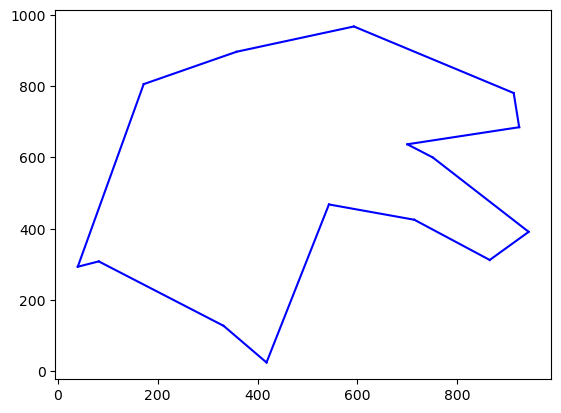

3450.0548865718392


In [22]:
tsp = TSP(15)
initial_tour = []
cities = tsp.cities.copy()  # Use copy() method to make a copy of the list
while len(cities) != 0 :
    randomStart = random.randint(0,len(cities) - 1)
    initial_tour.append(cities[randomStart])
    cities.remove(cities[randomStart])
tour , length = simulated_annealing(tsp,initial_tour)
tsp.plot_tour(tour)
print(length)

### Analysis

- The given code can calculate an acceptable approximated answer.
- use this code to compare your algorithms.

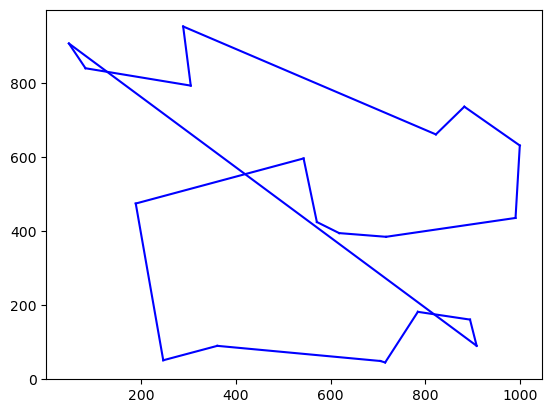

4932.481856017453


In [23]:
tsp = TSP(20)
tour = solve_tsp(tsp.distances)
path = [tsp.cities[i] for i in tour]
tsp.plot_tour(path)
print(tsp.tour_length(path))

- analyze the lengths you get from the two algorithms with different initial functions
- plot these tours and explain the results (results may be inconsistent as they are approximations)

treshhold :  4932.481856017453
lkh random :  3824.033798965184
lkh nn :  3824.0337989651835
lkh rnn :  4104.4472153565575
lkh beam :  3824.0337989651835
simulated random :  3966.8957184019414
simulated nn :  3824.033798965184
simulated rnn :  3947.7969722104835
simulated beam :  3824.033798965184


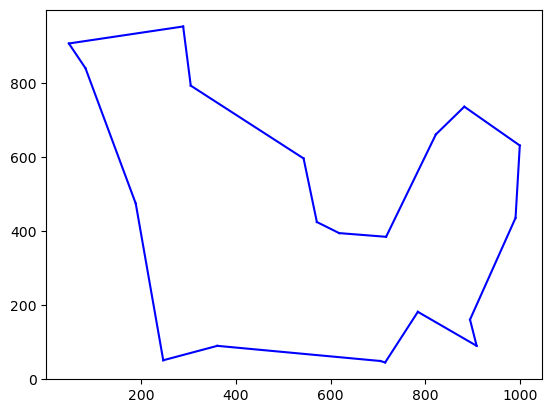

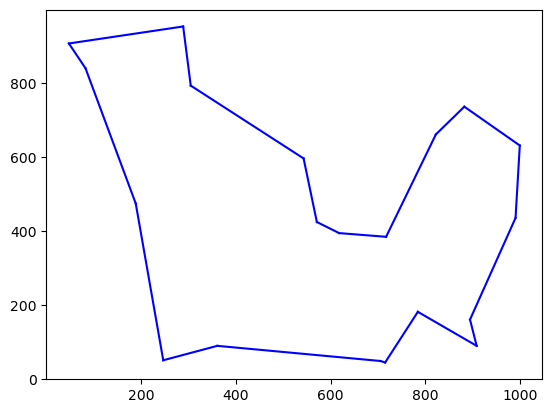

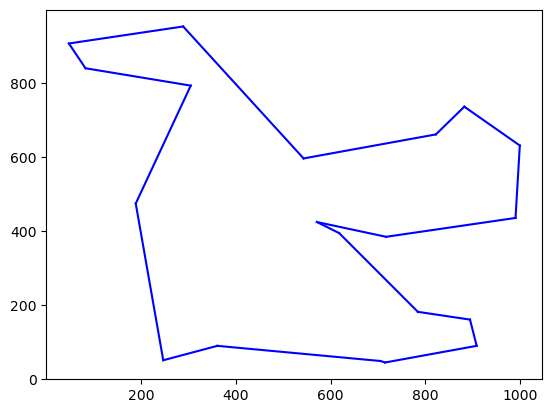

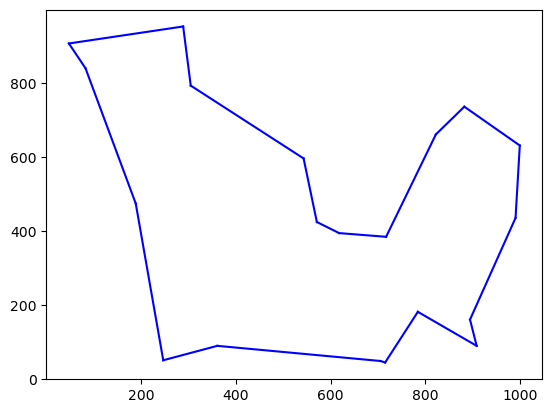

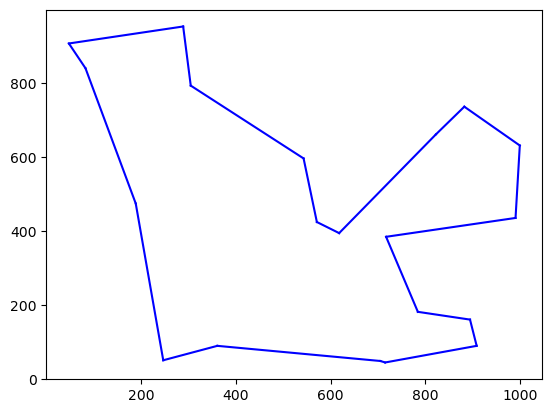

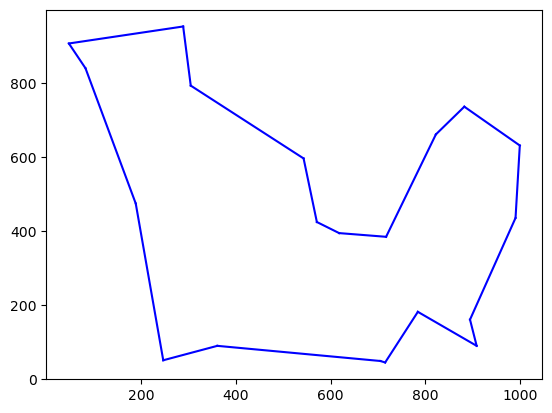

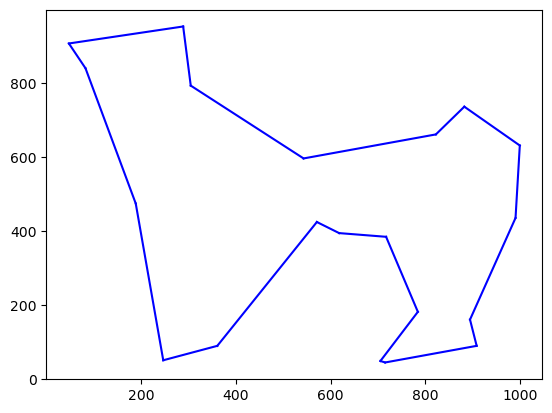

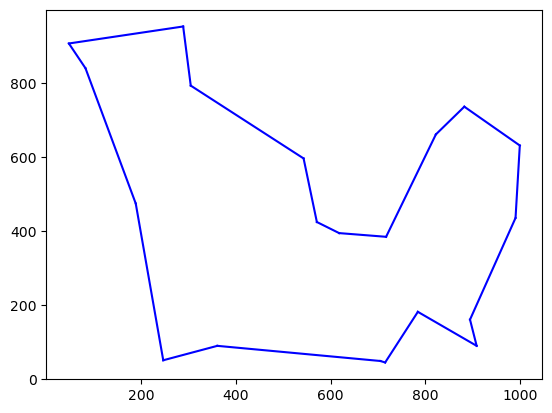

In [24]:
rtour , rlength = random_initial(tsp)
nntour , nnlength = nearest_neighbor_initial(tsp)
rnntour , rnnlength = repeated_nearest_neighbor_initial(tsp,10)
beamtour , beamlength = beam_search_initial(tsp,5,100)

lr_tour , lr_length = lin_kernighan(tsp,rtour)
lnn_tour , lnn_length = lin_kernighan(tsp,nntour)
lrnn_tour , lrnn_length = lin_kernighan(tsp,rnntour)
lbeam_tour , lbeam_length = lin_kernighan(tsp,beamtour)

sr_tour , sr_length = simulated_annealing(tsp,rtour)
snn_tour , snn_length = simulated_annealing(tsp,nntour)
srnn_tour , srnn_length = simulated_annealing(tsp,rnntour)
sbeam_tour , sbeam_length = simulated_annealing(tsp,beamtour)

#comparing answers numerically
print("treshhold : ",tsp.tour_length(path))
print("lkh random : ",lr_length)
print("lkh nn : ",lnn_length)
print("lkh rnn : ",lrnn_length)
print("lkh beam : ",lbeam_length)

print("simulated random : ",sr_length)
print("simulated nn : ",snn_length)
print("simulated rnn : ",srnn_length)
print("simulated beam : ",sbeam_length)

tsp.plot_tour(lr_tour)
tsp.plot_tour(lnn_tour)
tsp.plot_tour(lrnn_tour)
tsp.plot_tour(lbeam_tour)
tsp.plot_tour(sr_tour)
tsp.plot_tour(snn_tour)
tsp.plot_tour(srnn_tour)
tsp.plot_tour(sbeam_tour)